<font size="4" face="verdana" color="red"> Brainery Bytes
<hr></font>
<font size="6" face="verdana" color="blue">OpenSeesPy Graphics: <br>
    <b>Drawing the Integration-Point Curvature <br>on your OpenSees Model </b></font><p>

<font size="4" face="verdana" color="black">
 Silvia Mazzoni <br>
    R211001
    
 <br>
<font size="3" face="verdana" color="black">
    <p> In this Notebook we use the Interactive features of OpenSeesPy to represent the Integration-Point Curvatures graphically</p>
    <p> This examples works for both 2D and 3D models </p>
    
<font size="3" face="verdana" color="blue">
    This Code has been developed by Silvia Mazzoni. Please acknowledge this in your scripts, when applicable

## USER INPUT

In [1]:
# select model.
ModelType = '2D' # Options: '2D' and '3D'


In [2]:
if ModelType == '2D':
    thisModel = 'pyEx5.Frame2D.build.InelasticFiberRCSection'
else:
    thisModel = 'pyEx8.genericFrame3D.build.RCsec'

## UTILITIES


In [3]:
import openseespy.opensees as ops
import os
import math
import numpy as numpy
import matplotlib.pyplot as plt
import random
import matplotlib.cm as cm
from matplotlib.patches import Ellipse

import eSEESminiPy

In [4]:
%matplotlib notebook

In [5]:
%%javascript
// expand output box so graphs are viewed in notebook properly
IPython.OutputArea.auto_scroll_threshold = 100000;

<IPython.core.display.Javascript object>

In [6]:
# --------------------------------------------------------------------------------------------------
# LibUnits.tcl -- define system of units
# Silvia Mazzoni and Frank McKenna, 2006
#

# define UNITS ----------------------------------------------------------------------------
inch  = 1.  # define basic units -- output units
kip  = 1. # define basic units -- output units
sec  = 1. # define basic units -- output units
LunitTXT  = 'inch' # define basic-unit text for output
FunitTXT  = 'kip' # define basic-unit text for output
TunitTXT  = 'sec' # define basic-unit text for output
ft  = 12.*inch # define engineering units
ksi  = kip/math.pow(inch,2)
psi  = ksi/1000.
lbf  = psi*inch*inch # pounds force
pcf  = lbf/math.pow(ft,3) # pounds per cubic foot
psf  = lbf/math.pow(ft,3) # pounds per square foot
inch2  = inch*inch # inch^2
inch4  = inch*inch*inch*inch # inch^4
cm  = inch/2.54 # centimeter, needed for displacement input in MultipleSupport excitation
PI  = 2*math.asin(1.0) # define constants
g  = 32.2*ft/math.pow(sec,2) # gravitational acceleration
Ubig  = 1.e10 # a really large number
Usmall  = 1/Ubig # a really small number

In [7]:
def pyLibMaterialsRC():
    ############################################################
    #  EXAMPLE: 
    #       pyLibMaterialsRC.tcl.py
    #          for OpenSeesPy
    #  --------------------------------------------------------#
    #  by: Silvia Mazzoni, 2020
    #       silviamazzoni@yahoo.com
    ############################################################
    # This file was obtained from a conversion of the updated Tcl script
    # The Tcl script was obtained by updating the Examples Manual published in the OpenSees Wiki Page
    tclFilename = 'LibMaterialsRC.tcl'
    pyFilename = 'pyLibMaterialsRC.tcl.py'
    print(pyFilename)
    ############################################################

    ##########################################################
    # LibMaterialsRC.tcl: define a library of Reinforced-Concrete materials
    # Silvia Mazzoni and Frank McKenna, 2006
    ##########################################################

    # General Material parameters
    G  = Ubig # make stiff shear modulus
    J  = 1.0 # torsional section stiffness (G makes GJ large)
    GJ  = G*J

    # -----------------------------------------------------------------------------------------------------# confined and unconfined CONCRETE
    # nominal concrete compressive strength
    fc  = -4.0*ksi # CONCRETE Compressive Strength, ksi (+Tension, -Compression)
    Ec  = 57*ksi*math.sqrt(-fc/psi) # Concrete Elastic Modulus
    nu  = 0.2
    Gc  = Ec/2./(1+nu) # Torsional stiffness Modulus

    # confined concrete
    Kfc  = 1.3 # ratio of confined to unconfined concrete strength
    Kres  = 0.2 # ratio of residual/ultimate to maximum stress
    fc1C  = Kfc*fc # CONFINED concrete (mander model), maximum stress
    eps1C  = 2.*fc1C/Ec # strain at maximum stress
    fc2C  = Kres*fc1C # ultimate stress
    eps2C  = 20*eps1C # strain at ultimate stress
    Lambda  = 0.1 # ratio between unloading slope at eps2 and initial slope Ec
    # unconfined concrete
    fc1U  = fc # UNCONFINED concrete (todeschini parabolic model), maximum stress
    eps1U  = -0.003 # strain at maximum strength of unconfined concrete
    fc2U  = Kres*fc1U # ultimate stress
    eps2U  = -0.01 # strain at ultimate stress

    # tensile-strength properties
    ftC  = -0.14*fc1C # tensile strength+tension
    ftU  = -0.14*fc1U # tensile strength+tension
    Ets  = ftU/0.002 # tension softening stiffness

    # set up library of materials
    IDconcCore  = 1
    IDconcCover  = 2
    ops.uniaxialMaterial('Concrete02',IDconcCore,fc1C,eps1C,fc2C,eps2C,Lambda,ftC,Ets)     #  Core concrete (confined)
    ops.uniaxialMaterial('Concrete02',IDconcCover,fc1U,eps1U,fc2U,eps2U,Lambda,ftU,Ets)     #  Cover concrete (unconfined)

    # -----------------------------------------------------------------------------------------------------# REINFORCING STEEL parameters
    #
    Fy  = 66.8*ksi # STEEL yield stress
    Es  = 29000.*ksi # modulus of steel
    Bs  = 0.01 # strain-hardening ratio
    R0  = 18 # control the transition from elastic to plastic branches
    cR1  = 0.925 # control the transition from elastic to plastic branches
    cR2  = 0.15 # control the transition from elastic to plastic branches

    IDSteel  = 3
    ops.uniaxialMaterial('Steel02',IDSteel,Fy,Es,Bs,R0,cR1,cR2)
    return IDconcCore,IDconcCover,IDSteel


# Build OpenSees Model

## 2D Model: Ex5.Frame2D.build.InelasticFiber

In [8]:
if thisModel == 'pyEx5.Frame2D.build.InelasticFiberRCSection':
    DIM = '2D'
    ############################################################
    #  EXAMPLE: 
    #       pyEx5.Frame2D.build.InelasticFiberRCSection.tcl.py
    #          for OpenSeesPy
    #  --------------------------------------------------------#
    #  by: Silvia Mazzoni, 2020
    #       silviamazzoni@yahoo.com
    ############################################################
    # This file was obtained from a conversion of the updated Tcl script
    # The Tcl script was obtained by updating the Examples Manual published in the OpenSees Wiki Page
    tclFilename = 'Ex5.Frame2D.build.InelasticFiberRCSection.tcl'
    pyFilename = 'pyEx5.Frame2D.build.InelasticFiberRCSection.tcl.py'
    print(pyFilename)
    ############################################################


    # --------------------------------------------------------------------------------------------------
    # Example 5. 2D Frame -- Build Model
    # nonlinearBeamColumn element, inelastic fiber section -- Reinforced Concrete Section
    # Silvia Mazzoni and Frank McKenna, 2006
    #

    # # SET UP ----------------------------------------------------------------------------
    ops.wipe()     #  clear memory of all past model definitions
    ops.model('BasicBuilder','-ndm',2,'-ndf',3)     #  Define the model builder, ndm= dimension, ndf= dofs
    dataDir  = 'Data' # set up name of data directory (you can remove this)
    if not os.path.exists(dataDir):
        os.mkdir(dataDir)
    GMdir  = './GMfiles/' # ground-motion file directory

    # exec(open('pyLibUnits.tcl.py').read())
    # exec(open('pyLibBuildRCrectSection.tcl.py').read())
    #exec(open('pyLibDisplayPlane.tcl.py').read())
    #exec(open('pyLibDisplayModel2D.tcl.py').read())
    #exec(open('pyLibDisplayModel3D.tcl.py').read())

    # define GEOMETRY -------------------------------------------------------------
    # define structure-geometry paramters
    LCol  = 14*ft # column height
    LBeam  = 24*ft # beam length

    # calculate locations of beam/column intersections:
    X1  = 0.
    X2  = X1+LBeam
    X3  = X2+LBeam
    X4  = X3+LBeam
    Y1  = 0.
    Y2  = Y1+LCol
    Y3  = Y2+LCol
    Y4  = Y3+LCol

    # define nodal coordinates
    ops.node(11,X1,Y1)
    ops.node(12,X2,Y1)
    ops.node(13,X3,Y1)
    ops.node(14,X4,Y1)
    ops.node(21,X1,Y2)
    ops.node(22,X2,Y2)
    ops.node(23,X3,Y2)
    ops.node(24,X4,Y2)
    ops.node(31,X1,Y3)
    ops.node(32,X2,Y3)
    ops.node(33,X3,Y3)
    ops.node(34,X4,Y3)
    ops.node(41,X1,Y4)
    ops.node(42,X2,Y4)
    ops.node(43,X3,Y4)
    ops.node(44,X4,Y4)

    # Set up parameters that are particular to the model for displacement control
    IDctrlNode  = 41 # node where displacement is read for displacement control
    IDctrlDOF  = 1 # degree of freedom of displacement read for displacement control
    NStory  = 3 # number of stories above ground level
    NBay  = 3 # number of bays
    LBuilding  = Y4 # total building height

    # BOUNDARY CONDITIONS
    ops.fix(11,1,1,0)
    ops.fix(12,1,1,0)
    ops.fix(13,1,1,0)
    ops.fix(14,1,1,0)

    # Define SECTIONS -------------------------------------------------------------
    SectionType  = 'FiberSection' # options: Elastic FiberSection

    # define section tags:
    ColSecTag  = 1
    BeamSecTag  = 2

    # Section Properties:
    HCol  = 24*inch # square-Column width
    BCol  = HCol
    HBeam  = 42*inch # Beam depth -- perpendicular to bending axis
    BBeam  = 24*inch # Beam width -- parallel to bending axis

    if SectionType == 'Elastic' :
        # material properties:
        fc  = '4000*psi' # concrete nominal compressive strength
        Ec  = 57*ksi*math.pow(fc/psi,0.5) # concrete Young's Modulus
        # column section properties:
        AgCol  = HCol*BCol # rectuangular-Column cross-sectional area
        IzCol  = 0.5*1./12*BCol*math.pow(HCol,3) # about-local-z Rect-Column gross moment of inertial
        # beam sections:
        AgBeam  = HBeam*BBeam # rectuangular-Beam cross-sectional area
        IzBeam  = 0.5*1./12*BBeam*math.pow(HBeam,3) # about-local-z Rect-Beam cracked moment of inertial

        ops.section('Elastic',ColSecTag,Ec,AgCol,IzCol)
        ops.section('Elastic',BeamSecTag,Ec,AgBeam,IzBeam)

    elif SectionType == "FiberSection" :
        # MATERIAL parameters
    #     exec(open('pyLibMaterialsRC.tcl.py').read())
        IDconcCore,IDconcCover,IDSteel = pyLibMaterialsRC()
        
        # FIBER SECTION properties
        # Column section geometry:
        cover  = 2.5*inch # rectangular-RC-Column cover
        numBarsTopCol  = 8 # number of longitudinal-reinforcement bars on top layer
        numBarsBotCol  = 8 # number of longitudinal-reinforcement bars on bottom layer
        numBarsIntCol  = 6 # TOTAL number of reinforcing bars on the intermediate layers
        barAreaTopCol  = 1.*inch*inch # longitudinal-reinforcement bar area
        barAreaBotCol  = 1.*inch*inch # longitudinal-reinforcement bar area
        barAreaIntCol  = 1.*inch*inch # longitudinal-reinforcement bar area

        numBarsTopBeam  = 6 # number of longitudinal-reinforcement bars on top layer
        numBarsBotBeam  = 6 # number of longitudinal-reinforcement bars on bottom layer
        numBarsIntBeam  = 2 # TOTAL number of reinforcing bars on the intermediate layers
        barAreaTopBeam  = 1.*inch*inch # longitudinal-reinforcement bar area
        barAreaBotBeam  = 1.*inch*inch # longitudinal-reinforcement bar area
        barAreaIntBeam  = 1.*inch*inch # longitudinal-reinforcement bar area

        nfCoreY  = 20 # number of fibers in the core patch in the y direction
        nfCoreZ  = 20 # number of fibers in the core patch in the z direction
        nfCoverY  = 20 # number of fibers in the cover patches with long sides in the y direction
        nfCoverZ  = 20 # number of fibers in the cover patches with long sides in the z direction
        # rectangular section with one layer of steel evenly distributed around the perimeter and a confined core.
        eSEESminiPy.BuildRCrectSection(ColSecTag,HCol,BCol,cover,cover,IDconcCore,IDconcCover,IDSteel,numBarsTopCol,barAreaTopCol,numBarsBotCol,barAreaBotCol,numBarsIntCol,barAreaIntCol,nfCoreY,nfCoreZ,nfCoverY,nfCoverZ)
        eSEESminiPy.BuildRCrectSection(BeamSecTag,HBeam,BBeam,cover,cover,IDconcCore,IDconcCover,IDSteel,numBarsTopBeam,barAreaTopBeam,numBarsBotBeam,barAreaBotBeam,numBarsIntBeam,barAreaIntBeam,nfCoreY,nfCoreZ,nfCoverY,nfCoverZ)
    else :
        print(' "No section has been defined')


    # define ELEMENTS
    # set up geometric transformations of element
    # separate columns and beams, in case of P-Delta analysis for columns
    IDColTransf  = 1 # all columns
    IDBeamTransf  = 2 # all beams
    ColTransfType  = 'Linear'  # options, Linear PDelta Corotational
    ops.geomTransf(ColTransfType,IDColTransf)     #  only columns can have PDelta effects (gravity effects)
    ops.geomTransf('Linear',IDBeamTransf)

    # Define Beam-Column Elements
    np  = 5 # number of Gauss integration points for nonlinear curvature distribution-- np=2 for linear distribution ok
    # columns
    ops.element('nonlinearBeamColumn',111,11,21,np,ColSecTag,IDColTransf)     #  level 1-2
    ops.element('nonlinearBeamColumn',112,12,22,np,ColSecTag,IDColTransf)
    ops.element('nonlinearBeamColumn',113,13,23,np,ColSecTag,IDColTransf)
    ops.element('nonlinearBeamColumn',114,14,24,np,ColSecTag,IDColTransf)
    ops.element('nonlinearBeamColumn',121,21,31,np,ColSecTag,IDColTransf)     #  level 2-3
    ops.element('nonlinearBeamColumn',122,22,32,np,ColSecTag,IDColTransf)
    ops.element('nonlinearBeamColumn',123,23,33,np,ColSecTag,IDColTransf)
    ops.element('nonlinearBeamColumn',124,24,34,np,ColSecTag,IDColTransf)
    ops.element('nonlinearBeamColumn',131,31,41,np,ColSecTag,IDColTransf)     #  level 3-4
    ops.element('nonlinearBeamColumn',132,32,42,np,ColSecTag,IDColTransf)
    ops.element('nonlinearBeamColumn',133,33,43,np,ColSecTag,IDColTransf)
    ops.element('nonlinearBeamColumn',134,34,44,np,ColSecTag,IDColTransf)
    # beams
    ops.element('nonlinearBeamColumn',221,21,22,np,BeamSecTag,IDBeamTransf)     #  level 2
    ops.element('nonlinearBeamColumn',222,22,23,np,BeamSecTag,IDBeamTransf)     # element nonlinearBeamColumn 222 22 23 np BeamSecTag IDBeamTransf;
    ops.element('nonlinearBeamColumn',223,23,24,np,BeamSecTag,IDBeamTransf)     # element nonlinearBeamColumn 223 23 24 np BeamSecTag IDBeamTransf;
    ops.element('nonlinearBeamColumn',231,31,32,np,BeamSecTag,IDBeamTransf)     #  level 3
    ops.element('nonlinearBeamColumn',232,32,33,np,BeamSecTag,IDBeamTransf)     # element nonlinearBeamColumn 232 32 33 np BeamSecTag IDBeamTransf;
    ops.element('nonlinearBeamColumn',233,33,34,np,BeamSecTag,IDBeamTransf)     # element nonlinearBeamColumn 233 33 34 np BeamSecTag IDBeamTransf;
    ops.element('nonlinearBeamColumn',241,41,42,np,BeamSecTag,IDBeamTransf)     #  level 4
    ops.element('nonlinearBeamColumn',242,42,43,np,BeamSecTag,IDBeamTransf)     # element nonlinearBeamColumn 242 42 43 np BeamSecTag IDBeamTransf;
    ops.element('nonlinearBeamColumn',243,43,44,np,BeamSecTag,IDBeamTransf)     # element nonlinearBeamColumn 243 43 44 np BeamSecTag IDBeamTransf;

    # Define GRAVITY LOADS, weight and masses
    # calculate dead load of frame, assume this to be an internal frame (do LL in a similar manner)
    # calculate distributed weight along the beam length
    GammaConcrete  = 150*pcf # Reinforced-Concrete floor slabs
    Tslab  = 6*inch # 6-inch slab
    Lslab  = 2*LBeam/2 # assume slab extends a distance of LBeam1/2 in/out of plane
    Qslab  = GammaConcrete*Tslab*Lslab
    QBeam  = 94*lbf/ft # W-section weight per length
    QdlBeam  = Qslab+QBeam # dead load distributed along beam.
    QdlCol  = 114*lbf/ft # W-section weight per length
    WeightCol  = QdlCol*LCol # total Column weight
    WeightBeam  = QdlBeam*LBeam # total Beam weight

    # assign masses to the nodes that the columns are connected to
    # each connection takes the mass of 1/2 of each element framing into it (mass=weight/g)
    ops.mass(21,(WeightCol/2+WeightCol/2+WeightBeam/2)/g,0.,0.)     #  level 2
    ops.mass(22,(WeightCol/2+WeightCol/2+WeightBeam/2+WeightBeam/2)/g,0.,0.)     # mass 22 ((WeightCol/2+WeightCol/2+WeightBeam/2+WeightBeam/2)/g) 0. 0.;
    ops.mass(23,(WeightCol/2+WeightCol/2+WeightBeam/2+WeightBeam/2)/g,0.,0.)     # mass 23 ((WeightCol/2+WeightCol/2+WeightBeam/2+WeightBeam/2)/g) 0. 0.;
    ops.mass(24,(WeightCol/2+WeightCol/2+WeightBeam/2)/g,0.,0.)     # mass 24 ((WeightCol/2+WeightCol/2+WeightBeam/2)/g) 0. 0.;
    ops.mass(31,(WeightCol/2+WeightCol/2+WeightBeam/2)/g,0.,0.)     #  level 3
    ops.mass(32,(WeightCol/2+WeightCol/2+WeightBeam/2+WeightBeam/2)/g,0.,0.)     # mass 32 ((WeightCol/2+WeightCol/2+WeightBeam/2+WeightBeam/2)/g) 0. 0.;
    ops.mass(33,(WeightCol/2+WeightCol/2+WeightBeam/2+WeightBeam/2)/g,0.,0.)     # mass 33 ((WeightCol/2+WeightCol/2+WeightBeam/2+WeightBeam/2)/g) 0. 0.;
    ops.mass(34,(WeightCol/2+WeightCol/2+WeightBeam/2)/g,0.,0.)     # mass 34 ((WeightCol/2+WeightCol/2+WeightBeam/2)/g) 0. 0.;
    ops.mass(41,(WeightCol/2+WeightBeam/2)/g,0.,0.)     #  level 4
    ops.mass(42,(WeightCol/2+WeightBeam/2+WeightBeam/2)/g,0.,0.)     # mass 42 ((WeightCol/2+WeightBeam/2+WeightBeam/2)/g) 0. 0.;
    ops.mass(43,(WeightCol/2+WeightBeam/2+WeightBeam/2)/g,0.,0.)     # mass 43 ((WeightCol/2+WeightBeam/2+WeightBeam/2)/g) 0. 0.;
    ops.mass(44,(WeightCol/2+WeightBeam/2)/g,0.,0.)     # mass 44 ((WeightCol/2+WeightBeam/2)/g) 0. 0.;
    # calculate total Floor Mass
    WeightFloor2  = WeightCol*4/2+WeightCol*4/2+3*WeightBeam # level 2 weight
    WeightFloor3  = WeightCol*4/2+WeightCol*4/2+3*WeightBeam
    WeightFloor4  = WeightCol*4/2+3*WeightBeam
    WeightTotal  = WeightFloor2+WeightFloor3+WeightFloor4 # total frame weight
    MassFloor2  = WeightFloor2/g
    MassFloor3  = WeightFloor3/g
    MassFloor4  = WeightFloor4/g
    MassTotal  = MassFloor2+MassFloor3+MassFloor4 # total frame mass

    # LATERAL-LOAD distribution for static pushover analysis
    # calculate distribution of lateral load based on mass/weight distributions along building height
    # Fj = WjHj/sum(WiHi) * Weight at each floor j
    sumWiHi  = WeightFloor2*Y2+WeightFloor3*Y3+WeightFloor4*Y4 # denominator
    Fj2  = WeightFloor2*Y2/sumWiHi*WeightTotal # total for floor 2
    Fj3  = WeightFloor3*Y3/sumWiHi*WeightTotal # total for floor 3
    Fj4  = WeightFloor4*Y4/sumWiHi*WeightTotal # total for floor 4
    Fi2  = Fj2/4 # per node on floor 2
    Fi3  = Fj3/4 # per node on floor 3
    Fi4  = Fj4/4 # per node on floor 4
    iFi  = [Fi2,Fi3,Fi4] # vectorize
    
    iNodePush  = [21,31,41] # nodes for pushover/cyclic, vectorized
    iFPush  = iFi # lateral load for pushover, vectorized
    
    # define GRAVITY -------------------------------------------------------------
    # GRAVITY LOADS # define gravity load applied to beams and columns -- eleLoad applies loads in local coordinate axis
    ops.timeSeries('Linear',101)     # timeSeries Linear 101;
    # define Load Pattern
    ops.pattern('Plain',101,101) # 
    ops.eleLoad('-ele',221,222,223,'-type','-beamUniform',-QdlBeam)     #  beams level 2 (in -ydirection)
    ops.eleLoad('-ele',231,232,233,'-type','-beamUniform',-QdlBeam)     # eleLoad -ele 231 232 233 -type -beamUniform -QdlBeam;
    ops.eleLoad('-ele',241,242,243,'-type','-beamUniform',-QdlBeam)
    ops.eleLoad('-ele',111,112,113,114,'-type','-beamUniform',0,-QdlCol)     #  columns level 1-2 (in -xdirection)
    ops.eleLoad('-ele',121,122,123,124,'-type','-beamUniform',0,-QdlCol)     # eleLoad -ele 121 122 123 124 -type -beamUniform 0 -QdlCol;
    ops.eleLoad('-ele',131,132,133,134,'-type','-beamUniform',0,-QdlCol)     # eleLoad -ele 131 132 133 134 -type -beamUniform 0 -QdlCol;

    # Gravity-analysis parameters -- load-controlled static analysis
    Tol  = 1.0e-8 # convergence tolerance for test
    constraintsTypeGravity  = 'Plain' # default
    if 'RigidDiaphragm' in locals():
        if RigidDiaphragm=='ON' :
            constraintsTypeGravity  = 'Lagrange' # large model: try Transformation

    ops.wipeAnalysis()     # adding this to clear Analysis module 
    ops.constraints(constraintsTypeGravity)     #  how it handles boundary conditions
    ops.numberer('RCM')     #  renumber dofs to minimize band-width (optimization), if you want to
    ops.system('BandGeneral')     #  how to store and solve the system of equations in the analysis (large model: try UmfPack)
    ops.test('NormDispIncr',Tol,6)     #  determine if convergence has been achieved at the end of an iteration step
    ops.algorithm('Newton')     #  use Newtons solution algorithm: updates tangent stiffness at every iteration
    NstepGravity  = 10 # apply gravity in 10 steps
    DGravity  = 1./NstepGravity # first load increment
    ops.integrator('LoadControl',DGravity)     #  determine the next time step for an analysis
    ops.analysis('Static')     #  define type of analysis static or transient
    ops.analyze(NstepGravity)     #  apply gravity

    # ------------------------------------------------- maintain constant gravity loads and reset time to zero
    ops.loadConst('-time',0.0)

    print(' "Model Built')




pyEx5.Frame2D.build.InelasticFiberRCSection.tcl.py
pyLibMaterialsRC.tcl.py
 "Model Built


## 3D Model: pyEx8.genericFrame3D.build.RCsec

In [9]:
if thisModel == 'pyEx8.genericFrame3D.build.RCsec':
    DIM = '3D'
    ############################################################
    #  EXAMPLE: 
    #       pyEx8.genericFrame3D.build.RCsec.tcl.py
    #          for OpenSeesPy
    #  --------------------------------------------------------#
    #  by: Silvia Mazzoni, 2020
    #       silviamazzoni@yahoo.com
    ############################################################
    # This file was obtained from a conversion of the updated Tcl script
    # The Tcl script was obtained by updating the Examples Manual published in the OpenSees Wiki Page
    tclFilename = 'Ex8.genericFrame3D.build.RCsec.tcl'
    pyFilename = 'pyEx8.genericFrame3D.build.RCsec.tcl.py'
    print(pyFilename)
    ############################################################

    # --------------------------------------------------------------------------------------------------
    # Example 8. 3D RC frame
    # Silvia Mazzoni and Frank McKenna, 2006
    # nonlinearBeamColumn element, inelastic fiber section
    #

    # SET UP ----------------------------------------------------------------------------
    ops.wipe()     #  clear memory of all past model definitions
    ops.model('BasicBuilder','-ndm',3,'-ndf',6)     #  Define the model builder, ndm= dimension, ndf= dofs
    dataDir  = 'Data' # set up name of data directory
    if not os.path.exists(dataDir):
        os.mkdir(dataDir)
    GMdir  = './GMfiles' # ground-motion file directory

    # ------ frame configuration
    NStory  = 2 # number of stories above ground level
    NBay  = 2 # number of bays in X direction
    NBayZ  = 2 # number of bays in Z direction
    print(' "Number of Stories in Y: NStory Number of bays in X: NBay Number of bays in Z: NBayZ')
    NFrame  = NBayZ+1 # actually deal with frames in Z direction, as this is an easy extension of the 2d model

    # define GEOMETRY -------------------------------------------------------------
    # define structure-geometry paramters
    LCol  = 14*ft # column height (parallel to Y axis)
    LBeam  = 24*ft # beam length (parallel to X axis)
    LGird  = 24*ft # girder length (parallel to Z axis)

    # define NODAL COORDINATES
    Dlevel  = 10000 # numbering increment for new-level nodes
    Dframe  = 100 # numbering increment for new-frame nodes
    for frame in range(1,NFrame+1,1):
        Z  = (frame-1)*LGird
        for level in range(1,NStory+1+1,1):
            Y  = (level-1)*LCol
            for pier in range(1,NBay+1+1,1):
                X  = (pier-1)*LBeam
                nodeID  = level*Dlevel+frame*Dframe+pier
                ops.node(nodeID,X,Y,Z)     #  actually define node

    # rigid diaphragm nodes
    RigidDiaphragm  = 'ON'  # options: ON, OFF. specify this before the analysis parameters are set the constraints are handled differently.
    Xa  = (NBay*LBeam)/2 # mid-span coordinate for rigid diaphragm
    Za  = (NFrame-1)*LGird/2
    iMasterNode  = []
    for level in range(2,NStory+1+1,1):
        Y  = (level-1)*LCol
        # rigid-diaphragm nodes in center of each diaphram
        MasterNodeID  = 9900+level
        ops.node(MasterNodeID,Xa,Y,Za)     #  master nodes for rigid diaphragm
        ops.fix(MasterNodeID,0,1,0,1,0,1)     #  constrain other dofs that dont belong to rigid diaphragm control
        iMasterNode.append(MasterNodeID)
        perpDirn  = 2 # perpendicular to plane of rigid diaphragm
        for frame in range(1,NFrame+1,1):
            for pier in range(1,NBay+1+1,1):
                nodeID  = level*Dlevel+frame*Dframe+pier
                ops.rigidDiaphragm(perpDirn,MasterNodeID,nodeID)     #  define Rigid Diaphram,


    # determine support nodes where ground motions are input, for multiple-support excitation
    iSupportNode  = []
    for frame in range(1,NFrame+1,1):
        level  = 1
        for pier in range(1,NBay+1+1,1):
            nodeID  = level*Dlevel+frame*Dframe+pier
            iSupportNode.append(nodeID)


    # BOUNDARY CONDITIONS
    ops.fixY(0.0,1,1,1,0,1,0)     #  pin all Y=0.0 nodes

    # calculated MODEL PARAMETERS, particular to this model
    # Set up parameters that are particular to the model for displacement control
    IDctrlNode  = int((NStory+1)*Dlevel+(1*Dframe)+1) # node where displacement is read for displacement control
    IDctrlDOF  = 1  # degree of freedom of displacement read for displacement control
    LBuilding  = NStory*LCol # total building height

    # Define SECTIONS -------------------------------------------------------------
    SectionType  = 'FiberSection' # options: Elastic FiberSection

    # define section tags:
    ColSecTag  = 1
    BeamSecTag  = 2
    GirdSecTag  = 3
    ColSecTagFiber  = 4
    BeamSecTagFiber  = 5
    GirdSecTagFiber  = 6
    SecTagTorsion  = 70

    # Section Properties:
    HCol  = 18*inch # square-Column width
    BCol  = HCol
    HBeam  = 24*inch # Beam depth -- perpendicular to bending axis
    BBeam  = 18*inch # Beam width -- parallel to bending axis
    HGird  = 24*inch # Girder depth -- perpendicular to bending axis
    BGird  = 18*inch # Girder width -- parallel to bending axis

    if SectionType == 'Elastic' :
        # material properties:
        fc  = '4000*psi' # concrete nominal compressive strength
        Ec  = 57*ksi*math.pow(fc/psi,0.5) # concrete Young's Modulus
        nu  = 0.2 # Poisson's ratio
        Gc  = Ec/2./(1+nu) # Torsional stiffness Modulus
        J  = Ubig # set large torsional stiffness
        # column section properties:
        AgCol  = HCol*BCol # rectuangular-Column cross-sectional area
        IzCol  = 0.5*1./12*BCol*math.pow(HCol,3) # about-local-z Rect-Column gross moment of inertial
        IyCol  = 0.5*1./12*HCol*math.pow(BCol,3) # about-local-z Rect-Column gross moment of inertial
        # beam sections:
        AgBeam  = HBeam*BBeam # rectuangular-Beam cross-sectional area
        IzBeam  = 0.5*1./12*BBeam*math.pow(HBeam,3) # about-local-z Rect-Beam cracked moment of inertial
        IyBeam  = 0.5*1./12*HBeam*math.pow(BBeam,3) # about-local-y Rect-Beam cracked moment of inertial
        # girder sections:
        AgGird  = HGird*BGird # rectuangular-Girder cross-sectional area
        IzGird  = 0.5*1./12*BGird*math.pow(HGird,3) # about-local-z Rect-Girder cracked moment of inertial
        IyGird  = 0.5*1./12*HGird*math.pow(BGird,3) # about-local-y Rect-Girder cracked moment of inertial

        ops.section('Elastic',ColSecTag,Ec,AgCol,IzCol,IyCol,Gc,J)
        ops.section('Elastic',BeamSecTag,Ec,AgBeam,IzBeam,IyBeam,Gc,J)
        ops.section('Elastic',GirdSecTag,Ec,AgGird,IzGird,IyGird,Gc,J)

        IDconcCore  = 1 # material numbers for recorder (this stressstrain recorder will be blank, as this is an elastic section)
        IDSteel  = 2 # material numbers for recorder (this stressstrain recorder will be blank, as this is an elastic section)

    elif SectionType == "FiberSection" :
        # MATERIAL parameters
        IDconcCore,IDconcCover,IDSteel = pyLibMaterialsRC()
        # FIBER SECTION properties
        # Column section geometry:
        cover  = 2.5*inch # rectangular-RC-Column cover
        numBarsTopCol  = 8 # number of longitudinal-reinforcement bars on top layer
        numBarsBotCol  = 8 # number of longitudinal-reinforcement bars on bottom layer
        numBarsIntCol  = 6 # TOTAL number of reinforcing bars on the intermediate layers
        barAreaTopCol  = 1.*inch*inch # longitudinal-reinforcement bar area
        barAreaBotCol  = 1.*inch*inch # longitudinal-reinforcement bar area
        barAreaIntCol  = 1.*inch*inch # longitudinal-reinforcement bar area

        numBarsTopBeam  = 6 # number of longitudinal-reinforcement bars on top layer
        numBarsBotBeam  = 6 # number of longitudinal-reinforcement bars on bottom layer
        numBarsIntBeam  = 2 # TOTAL number of reinforcing bars on the intermediate layers
        barAreaTopBeam  = 1.*inch*inch # longitudinal-reinforcement bar area
        barAreaBotBeam  = 1.*inch*inch # longitudinal-reinforcement bar area
        barAreaIntBeam  = 1.*inch*inch # longitudinal-reinforcement bar area

        numBarsTopGird  = 6 # number of longitudinal-reinforcement bars on top layer
        numBarsBotGird  = 6 # number of longitudinal-reinforcement bars on bottom layer
        numBarsIntGird  = 2 # TOTAL number of reinforcing bars on the intermediate layers
        barAreaTopGird  = 1.*inch*inch # longitudinal-reinforcement bar area
        barAreaBotGird  = 1.*inch*inch # longitudinal-reinforcement bar area
        barAreaIntGird  = 1.*inch*inch # longitudinal-reinforcement bar area

        nfCoreY  = 12 # number of fibers in the core patch in the y direction
        nfCoreZ  = 12 # number of fibers in the core patch in the z direction
        nfCoverY  = 8 # number of fibers in the cover patches with long sides in the y direction
        nfCoverZ  = 8 # number of fibers in the cover patches with long sides in the z direction
        # rectangular section with one layer of steel evenly distributed around the perimeter and a confined core.
        eSEESminiPy.BuildRCrectSection(ColSecTagFiber,HCol,BCol,cover,cover,IDconcCore,IDconcCover,IDSteel,numBarsTopCol,barAreaTopCol,numBarsBotCol,barAreaBotCol,numBarsIntCol,barAreaIntCol,nfCoreY,nfCoreZ,nfCoverY,nfCoverZ)
        eSEESminiPy.BuildRCrectSection(BeamSecTagFiber,HBeam,BBeam,cover,cover,IDconcCore,IDconcCover,IDSteel,numBarsTopBeam,barAreaTopBeam,numBarsBotBeam,barAreaBotBeam,numBarsIntBeam,barAreaIntBeam,nfCoreY,nfCoreZ,nfCoverY,nfCoverZ)
        eSEESminiPy.BuildRCrectSection(GirdSecTagFiber,HGird,BGird,cover,cover,IDconcCore,IDconcCover,IDSteel,numBarsTopGird,barAreaTopGird,numBarsBotGird,barAreaBotGird,numBarsIntGird,barAreaIntGird,nfCoreY,nfCoreZ,nfCoverY,nfCoverZ)

        # assign torsional Stiffness for 3D Model
        ops.uniaxialMaterial('Elastic',SecTagTorsion,Ubig)
        ops.section('Aggregator',ColSecTag,SecTagTorsion,'T','-section',ColSecTagFiber)
        ops.section('Aggregator',BeamSecTag,SecTagTorsion,'T','-section',BeamSecTagFiber)
        ops.section('Aggregator',GirdSecTag,SecTagTorsion,'T','-section',GirdSecTagFiber)
    else :
        print(' "No section has been defined')

    GammaConcrete  = 150*pcf
    QdlCol  = GammaConcrete*HCol*BCol # self weight of Column, weight per length
    QBeam  = GammaConcrete*HBeam*BBeam # self weight of Beam, weight per length
    QGird  = GammaConcrete*HGird*BGird # self weight of Gird, weight per length

    # --------------------------------------------------------------------------------------------------------------------------------
    # define ELEMENTS
    # set up geometric transformations of element
    # separate columns and beams, in case of P-Delta analysis for columns
    IDColTransf  = 1 # all columns
    IDBeamTransf  = 2 # all beams
    IDGirdTransf  = 3 # all girds
    ColTransfType  = 'Linear'  # options for columns: Linear PDelta Corotational
    ops.geomTransf(ColTransfType,IDColTransf,0,0,1)     #  orientation of column stiffness affects bidirectional response.
    ops.geomTransf('Linear',IDBeamTransf,0,0,1)
    ops.geomTransf('Linear',IDGirdTransf,1,0,0)

    # Define Beam-Column Elements
    numIntgrPts  = 5 # number of Gauss integration points for nonlinear curvature distribution
    # columns
    N0col  = 10000-1 # column element numbers
    level  = 0
    for frame in range(1,NFrame+1,1):
        for level in range(1,NStory+1,1):
            for pier in range(1,NBay+1+1,1):
                elemID  = N0col +level*Dlevel+frame*Dframe+pier
                nodeI  = level*Dlevel+frame*Dframe+pier
                nodeJ  = (level+1)*Dlevel+frame*Dframe+pier
                ops.element('nonlinearBeamColumn',elemID,nodeI,nodeJ,numIntgrPts,ColSecTag,IDColTransf)     #  columns


    # beams -- parallel to X-axis
    N0beam  = 1000000 # beam element numbers
    for frame in range(1,NFrame+1,1):
        for level in range(2,NStory+1+1,1):
            for bay in range(1,NBay+1,1):
                elemID  = N0beam+level*Dlevel+frame*Dframe+bay
                nodeI  = level*Dlevel+frame*Dframe+bay
                nodeJ  = level*Dlevel+frame*Dframe+bay+1
                ops.element('nonlinearBeamColumn',elemID,nodeI,nodeJ,numIntgrPts,BeamSecTag,IDBeamTransf)     #  beams

    # girders -- parallel to Z-axis
    N0gird  = 2000000 # gird element numbers
    for frame in range(1,NFrame-1+1,1):
        for level in range(2,NStory+1+1,1):
            for bay in range(1,NBay+1+1,1):
                elemID  = N0gird+level*Dlevel+frame*Dframe+bay
                nodeI  = level*Dlevel+frame*Dframe+bay
                nodeJ  = level*Dlevel+(frame+1)*Dframe+bay
                ops.element('nonlinearBeamColumn',elemID,nodeI,nodeJ,numIntgrPts,GirdSecTag,IDGirdTransf)     #  Girds
 

    # --------------------------------------------------------------------------------------------------------------------------------
    # Define GRAVITY LOADS, weight and masses
    # calculate dead load of frame, assume this to be an internal frame (do LL in a similar manner)
    # calculate distributed weight along the beam length
    #set GammaConcrete (150*pcf) ##xx##  # Reinforced-Concrete floor slabs, defined above
    Tslab  = 6*inch # 6-inch slab
    Lslab  = LGird/2 # slab extends a distance of LGird/2 in/out of plane
    DLfactor  = 1.0 # scale dead load up a little
    Qslab  = GammaConcrete*Tslab*Lslab*DLfactor
    QdlBeam  = Qslab+QBeam # dead load distributed along beam (one-way slab)
    QdlGird  = QGird # dead load distributed along girder
    WeightCol  = QdlCol*LCol # total Column weight
    WeightBeam  = QdlBeam*LBeam # total Beam weight
    WeightGird  = QdlGird*LGird # total Beam weight

    # assign masses to the nodes that the columns are connected to
    # each connection takes the mass of 1/2 of each element framing into it (mass=weight/g)
    iFloorWeight  = []
    WeightTotal  = 0.0
    sumWiHi  = 0.0 # sum of storey weight times height, for lateral-load distribution

    for frame in range(1,NFrame+1,1):
        if frame == 1 or frame == NFrame :
            GirdWeightFact  = 1 # 1x1/2girder on exterior frames
        else :
            GirdWeightFact  = 2 # 2x1/2girder on interior frames

        for level in range(2,NStory+1+1,1):
            FloorWeight  = 0.0
            if level == (NStory+1) :
                ColWeightFact  = 1 # one column in top story
            else :
                ColWeightFact  = 2 # two columns elsewhere

            for pier in range(1,NBay+1+1,1):
                if pier == 1 or pier == (NBay+1) :
                    BeamWeightFact  = 1 # one beam at exterior nodes
                else :
                    BeamWeightFact  = 2 # two beams elewhere

                WeightNode  = ColWeightFact*WeightCol/2+BeamWeightFact*WeightBeam/2+GirdWeightFact*WeightGird/2
                MassNode  = WeightNode/g
                nodeID  = level*Dlevel+frame*Dframe+pier
                ops.mass(nodeID,MassNode,0.,MassNode,0.,0.,0.)     #  define mass
                FloorWeight  = FloorWeight+WeightNode

            iFloorWeight.append(FloorWeight)
            WeightTotal  = WeightTotal+FloorWeight
            sumWiHi  = sumWiHi+FloorWeight*(level-1)*LCol # sum of storey weight times height, for lateral-load distribution

    MassTotal  = WeightTotal/g  # total mass

    #------------------------------------------------------------------------------------------------------------------
    #Eigenvalue analysis

    numModes  = 3
    Lambda  = ops.eigen('-fullGenLapack',numModes)

    # calculate frequencies and periods of the structure ---------------------------------------------------
    omega  = []
    f  = []
    T  = []
    pi  = 3.141593

    for lam in Lambda :
        omega.append((math.sqrt(lam)))
        f.append((math.sqrt(lam)/(2*pi)))
        T.append(((2*pi)/math.sqrt(lam)))


    print(' "periods are T')

    # --------------------------------------------------------------------------------------------------------------------------------
    # LATERAL-LOAD distribution for static pushover analysis
    # calculate distribution of lateral load based on mass/weight distributions along building height
    # Fj = WjHj/sum(WiHi) * Weight at each floor j
    iFi  = []
    for level in range(2,NStory+1+1,1):
        FloorWeight  = iFloorWeight[(level-1-1)]
        FloorHeight  = (level-1)*LCol
        iFi.append((FloorWeight*FloorHeight/sumWiHi*WeightTotal))

    iNodePush  = iMasterNode # nodes for pushover/cyclic, vectorized
    iFPush  = iFi # lateral load for pushover, vectorized

    # GRAVITY -------------------------------------------------------------
    # define GRAVITY load applied to beams and columns -- eleLoad applies loads in local coordinate axis
    ops.timeSeries('Linear',101)     # timeSeries Linear 101;
    # define Load Pattern
    ops.pattern('Plain',101,101) # 
    for frame in range(1,NFrame+1,1):
        for level in range(1,NStory+1,1):
            for pier in range(1,NBay+1+1,1):
                elemID  = N0col +level*Dlevel+frame*Dframe+pier
                ops.eleLoad('-ele',elemID,'-type','-beamUniform',0.,0.,-QdlCol)	#  COLUMNS }

            for frame in range(1,NFrame+1,1):
                for level in range(2,NStory+1+1,1):
                    for bay in range(1,NBay+1,1):
                        elemID  = N0beam+level*Dlevel+frame*Dframe+bay
                        ops.eleLoad('-ele',elemID,'-type','-beamUniform',-QdlBeam,0.)     #  BEAMS

            for frame in range(1,NFrame-1+1,1):
                for level in range(2,NStory+1+1,1):
                    for bay in range(1,NBay+1+1,1):
                        elemID  = N0gird+level*Dlevel+frame*Dframe+bay
                        ops.eleLoad('-ele',elemID,'-type','-beamUniform',-QdlGird,0.)     #  GIRDS

        print(' goGravity')
        # Gravity-analysis parameters -- load-controlled static analysis
        Tol  = 1.0e-8 # convergence tolerance for test
        constraintsTypeGravity  = 'Plain' # default
        if 'RigidDiaphragm' in locals():
            if RigidDiaphragm=='ON' :
                constraintsTypeGravity  = 'Transformation' # large model: try Transformation

        ops.wipeAnalysis()     # adding this to clear Analysis module 
        ops.constraints(constraintsTypeGravity)     #  how it handles boundary conditions
        ops.numberer('RCM')     #  renumber dofs to minimize band-width (optimization), if you want to
        ops.system('BandGeneral')     #  how to store and solve the system of equations in the analysis (large model: try UmfPack)
        ops.test('EnergyIncr',Tol,6)     #  determine if convergence has been achieved at the end of an iteration step
        ops.algorithm('Newton')     #  use Newtons solution algorithm: updates tangent stiffness at every iteration
        NstepGravity  = 10 # apply gravity in 10 steps
        DGravity  = 1./NstepGravity # first load increment
        ops.integrator('LoadControl',DGravity)     #  determine the next time step for an analysis
        ops.analysis('Static')     #  define type of analysis static or transient
        ops.analyze(NstepGravity)     #  apply gravity

        # ------------------------------------------------- maintain constant gravity loads and reset time to zero
        ops.loadConst('-time',0.0)

        # -------------------------------------------------------------
        print(' "Model Built')

        print('End of Run: pyEx8.genericFrame3D.build.RCsec.tcl.py')


<IPython.core.display.Javascript object>


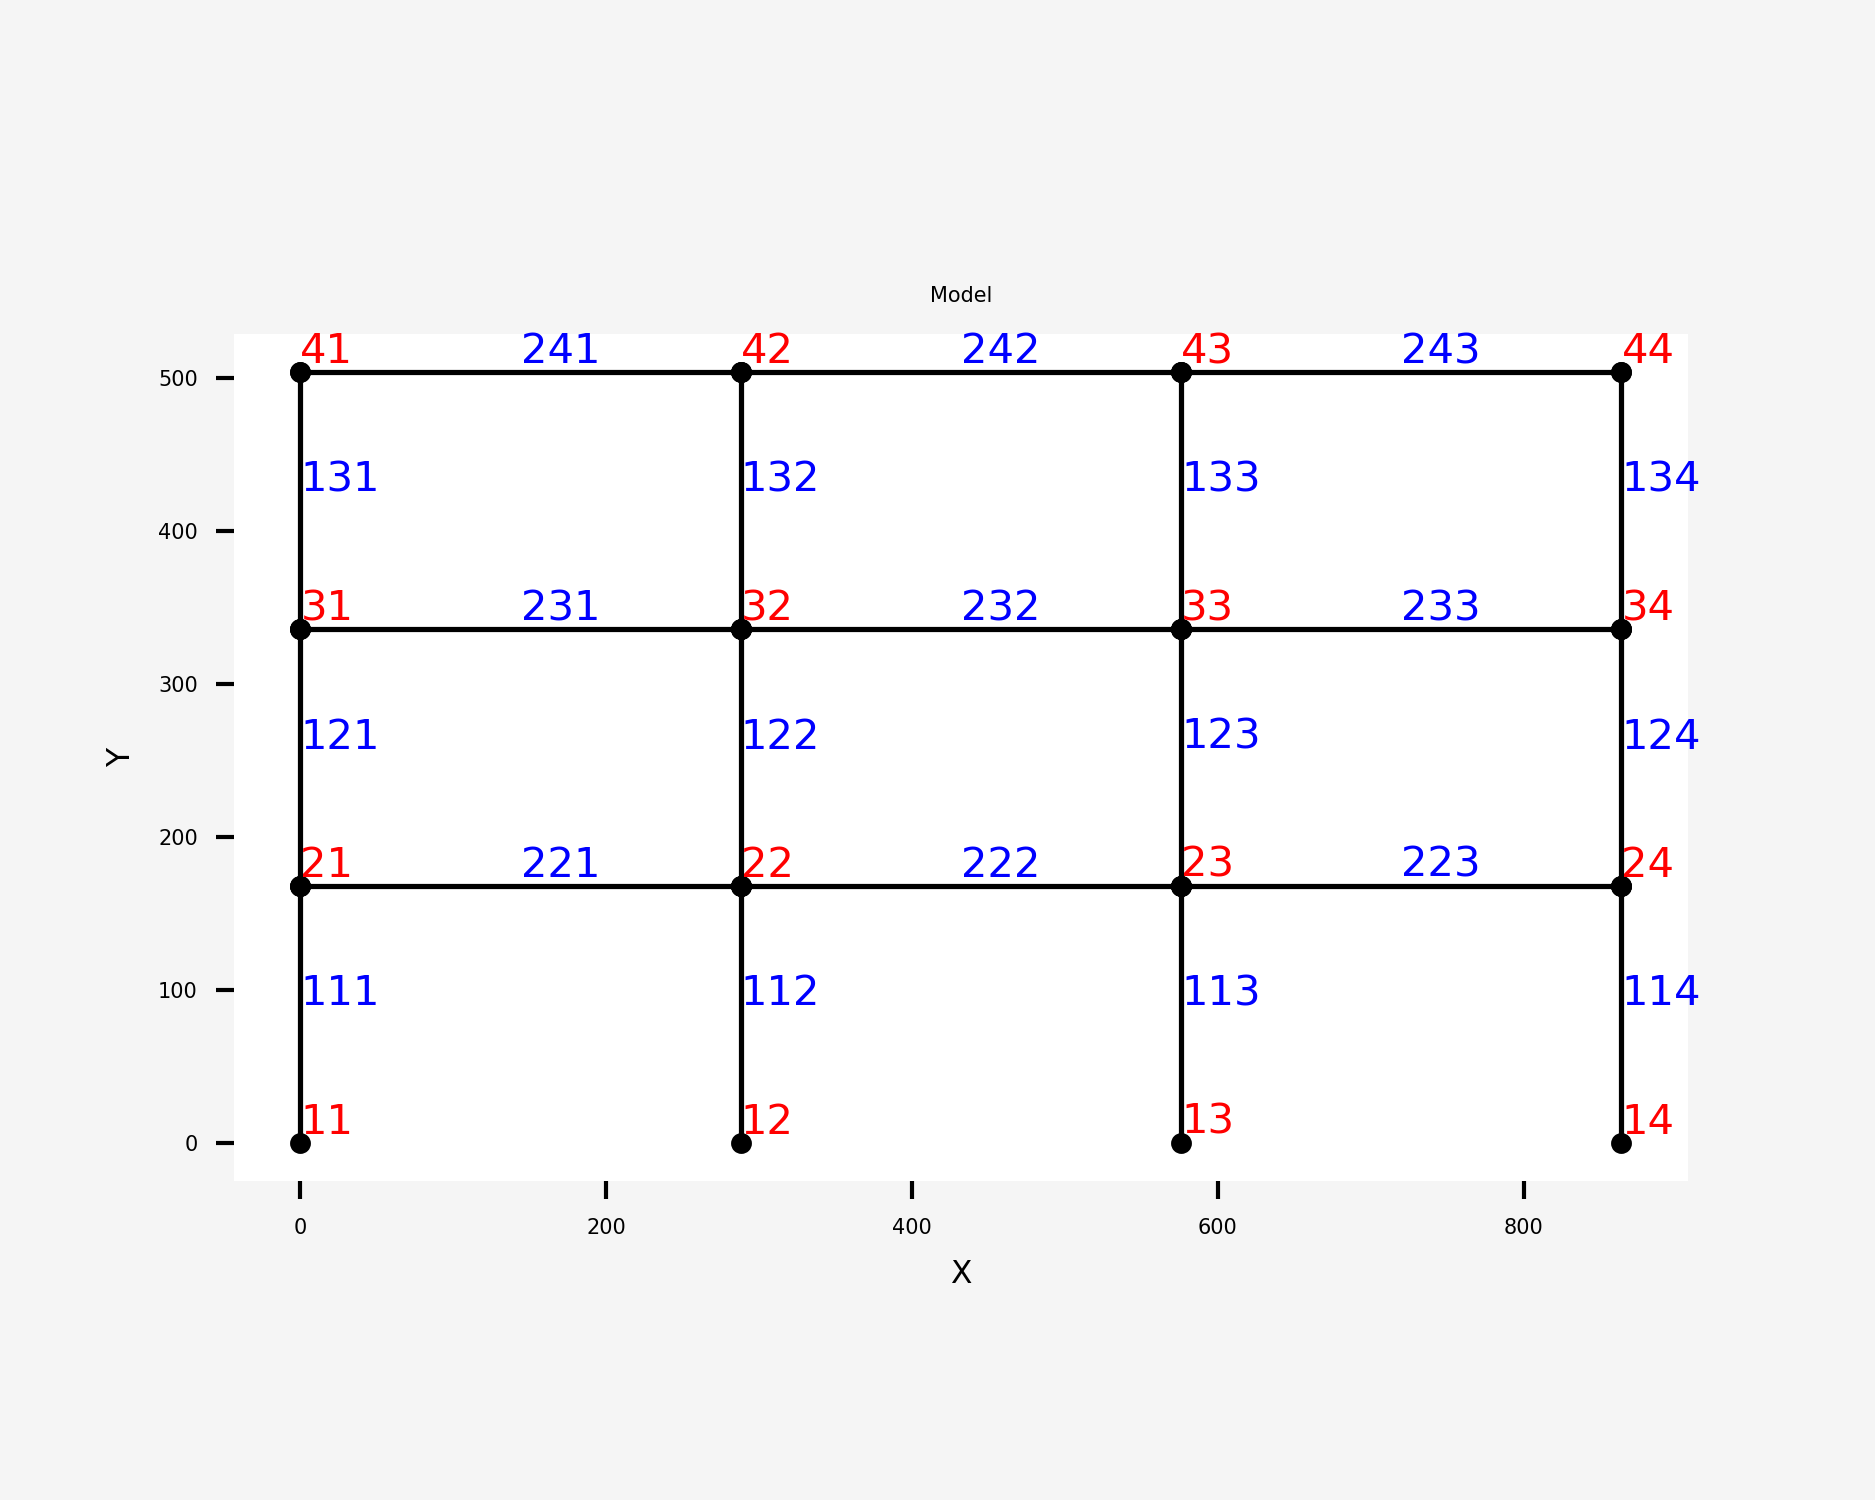

(<Figure size 1000x800 with 1 Axes>,
 <AxesSubplot:title={'center':'Model'}, xlabel='X', ylabel='Y'>)

In [10]:
eSEESminiPy.DrawModel()

# Static Pushover

In [11]:

############################################################
#  EXAMPLE: 
#       pyEx5.Frame2D.analyze.Static.Push.tcl.py
#          for OpenSeesPy
#  --------------------------------------------------------#
#  by: Silvia Mazzoni, 2020
#       silviamazzoni@yahoo.com
############################################################
# This file was obtained from a conversion of the updated Tcl script
# The Tcl script was obtained by updating the Examples Manual published in the OpenSees Wiki Page
tclFilename = 'Ex5.Frame2D.analyze.Static.Push.tcl'
pyFilename = 'pyEx5.Frame2D.analyze.Static.Push.tcl.py'
print(pyFilename)
############################################################

# start inserting this into every OpenSeesPy script
#import openseespy.opensees as ops
#import os
#import math
#import numpy as np
#import matplotlib.pyplot as plt
# ops.wipe()
# end of inserting this into every OpenSeesPy script
# --------------------------------------------------------------------------------------------------
# Example 5. 2D Frame -- Static Pushover Analysis
#    Silvia Mazzoni and Frank McKenna, 2006
# execute this file after you have built the model, and after you apply gravity
#

# characteristics of pushover analysis
Dmax  = 0.1*LBuilding  # maximum displacement of pushover. push to 10% drift.
Dincr  = 0.0001*LBuilding  # displacement increment. you want this to be small, but not too small to slow analysis

# -- STATIC PUSHOVER/CYCLIC ANALYSIS
# create load pattern for lateral pushover load coefficient when using linear load pattern
ops.timeSeries('Linear',200)     # timeSeries Linear 200;
# define Load Pattern
ops.pattern('Plain',200,200) # ; # define load pattern

for (NodePush,FPush) in zip(iNodePush,iFPush) :
    if DIM == '2D':
        ops.load(NodePush,FPush,0.0,0.0)
    else:
        ops.load(NodePush,FPush,0.0,0.0,0.0,0.0,0.0)


# ----------- set up analysis parameters
#exec(open('pyLibAnalysisStaticParameters.tcl.py').read())


pyEx5.Frame2D.analyze.Static.Push.tcl.py


In [12]:
############################################################
#  EXAMPLE: 
#       pyLibAnalysisStaticParameters.tcl.py
#          for OpenSeesPy
#  --------------------------------------------------------#
#  by: Silvia Mazzoni, 2020
#       silviamazzoni@yahoo.com
############################################################
# This file was obtained from a conversion of the updated Tcl script
# The Tcl script was obtained by updating the Examples Manual published in the OpenSees Wiki Page
#     tclFilename = 'LibAnalysisStaticParameters.tcl'
#     pyFilename = 'pyLibAnalysisStaticParameters.tcl.py'
#     print(pyFilename)
############################################################

# --------------------------------------------------------------------------------------------------
# static analysis parameters
# I am setting all these variables as global variables (using variable rather than set command)
# so that these variables can be uploaded by a procedure
#     Silvia Mazzoni and Frank McKenna, 2006
#

# CONSTRAINTS handler -- Determines how the constraint equations are enforced in the analysis (http://opensees.berkeley.edu/OpenSees/manuals/usermanual/617.htm)
#  Plain Constraints -- Removes constrained degrees of freedom from the system of equations (only for homogeneous equations)
#  Lagrange Multipliers -- Uses the method of Lagrange multipliers to enforce constraints
#  Penalty Method -- Uses penalty numbers to enforce constraints --good for static analysis with non-homogeneous eqns (rigidDiaphragm)
#  Transformation Method -- Performs a condensation of constrained degrees of freedom
constraintsTypeStatic  = 'Plain' # default
if 'RigidDiaphragm' in locals():
    if RigidDiaphragm=='ON' :
        constraintsTypeStatic  = 'Lagrange' # for large model, try Transformation
ops.wipeAnalysis()     # adding this to clear Analysis module 
ops.constraints(constraintsTypeStatic)

# DOF NUMBERER (number the degrees of freedom in the domain): (http://opensees.berkeley.edu/OpenSees/manuals/usermanual/366.htm)
# determines the mapping between equation numbers and degrees-of-freedom
#  Plain -- Uses the numbering provided by the user
#  RCM -- Renumbers the DOF to minimize the matrix band-width using the Reverse Cuthill-McKee algorithm
numbererTypeStatic  = 'RCM'
ops.numberer(numbererTypeStatic)

# SYSTEM (http://opensees.berkeley.edu/OpenSees/manuals/usermanual/371.htm)
# Linear Equation Solvers (how to store and solve the system of equations in the analysis)
# -- provide the solution of the linear system of equations Ku = P. Each solver is tailored to a specific matrix topology.
#  ProfileSPD -- Direct profile solver for symmetric positive definite matrices
#  BandGeneral -- Direct solver for banded unsymmetric matrices
#  BandSPD -- Direct solver for banded symmetric positive definite matrices
#  SparseGeneral -- Direct solver for unsymmetric sparse matrices
#  SparseSPD -- Direct solver for symmetric sparse matrices
#  UmfPack -- Direct UmfPack solver for unsymmetric matrices
systemTypeStatic  = 'BandGeneral' # try UmfPack for large model
ops.system(systemTypeStatic)

# TEST: # convergence test to
# Convergence TEST (http://opensees.berkeley.edu/OpenSees/manuals/usermanual/360.htm)
# -- Accept the current state of the domain as being on the converged solution path
# -- determine if convergence has been achieved at the end of an iteration step
#  NormUnbalance -- Specifies a tolerance on the norm of the unbalanced load at the current iteration
#  NormDispIncr -- Specifies a tolerance on the norm of the displacement increments at the current iteration
#  EnergyIncr-- Specifies a tolerance on the inner product of the unbalanced load and displacement increments at the current iteration
#  RelativeNormUnbalance --
#  RelativeNormDispIncr --
#  RelativeEnergyIncr --
TolStatic  = 1.e-8   # Convergence Test: tolerance
maxNumIterStatic  = 6  # Convergence Test: maximum number of iterations that will be performed before [failure,to,converge] is returned
printFlagStatic  = 0  # Convergence Test: flag used to print information on convergence (optional) # 1: print information on each step
testTypeStatic  = 'EnergyIncr'  # Convergence-test type
ops.test(testTypeStatic,TolStatic,maxNumIterStatic,printFlagStatic)     # test testTypeStatic TolStatic maxNumIterStatic printFlagStatic;
# for improved-convergence procedure:
maxNumIterConvergeStatic  = 2000
printFlagConvergeStatic  = 0


# Solution ALGORITHM: -- Iterate from the last time step to the current (http://opensees.berkeley.edu/OpenSees/manuals/usermanual/682.htm)
#  Linear -- Uses the solution at the first iteration and continues
#  Newton -- Uses the tangent at the current iteration to iterate to convergence
#  ModifiedNewton -- Uses the tangent at the first iteration to iterate to convergence
#  NewtonLineSearch --
#  KrylovNewton --
#  BFGS --
#  Broyden --
algorithmTypeStatic  = 'Newton'
ops.algorithm(algorithmTypeStatic)     # algorithm algorithmTypeStatic;

# Static INTEGRATOR: -- determine the next time step for an analysis (http://opensees.berkeley.edu/OpenSees/manuals/usermanual/689.htm)
#  LoadControl -- Specifies the incremental load factor to be applied to the loads in the domain
#  DisplacementControl -- Specifies the incremental displacement at a specified DOF in the domain
#  Minimum Unbalanced Displacement Norm -- Specifies the incremental load factor such that the residual displacement norm in minimized
#  Arc Length -- Specifies the incremental arc-length of the load-displacement path
# Transient INTEGRATOR: -- determine the next time step for an analysis including inertial effects
#  Newmark -- The two parameter time-stepping method developed by Newmark
#  HHT -- The three parameter Hilbert-Hughes-Taylor time-stepping method
#  Central Difference -- Approximates velocity and acceleration by centered finite differences of displacement
ops.integrator('DisplacementControl',IDctrlNode,IDctrlDOF,Dincr)

# ANALYSIS -- defines what type of analysis is to be performed (http://opensees.berkeley.edu/OpenSees/manuals/usermanual/324.htm)
#  Static Analysis -- solves the KU=R problem, without the mass or damping matrices.
#  Transient Analysis -- solves the time-dependent analysis. The time step in this type of analysis is constant. The time step in the output is also constant.
#  variableTransient Analysis -- performs the same analysis type as the Transient Analysis object. The time step, however, is variable. This method is used when
#   there are convergence problems with the Transient Analysis object at a peak or when the time step is too small. The time step in the output is also variable.
analysisTypeStatic  = 'Static'
ops.analysis(analysisTypeStatic)



In [13]:
# --------------------------------- perform Static Pushover Analysis
Nsteps  = int(Dmax/Dincr) # number of pushover analysis steps
ok  = ops.analyze(Nsteps)  # this will return zero if no convergence problems were encountered
#fmt1 = [%s,Pushover,analysis:,CtrlNode,%.3i,dof,%.1i,Disp=%.4f,%s] # format for screen/file output of DONE/PROBLEM analysis
if ok != 0 :
    # if analysis fails, we try some other stuff, performance is slower inside this loop
    Dstep  = 0.0
    ok  = 0
    while Dstep <= 1.0 and ok == 0 :
        controlDisp  = ops.nodeDisp(IDctrlNode,IDctrlDOF) 
        Dstep  = controlDisp/Dmax
        ok  = ops.analyze(1)
        # if analysis fails, we try some other stuff
        # performance is slower inside this loop global maxNumIterStatic ##xx##  # max no. of iterations performed before "failure to converge" is ret'd
        if ok != 0 :
            print(' "Trying Newton with Initial Tangent ..')
            ops.test('NormDispIncr',Tol,2000,0)
            ops.algorithm('Newton','-initial')
            ok  = ops.analyze(1)
            ops.test(testTypeStatic,TolStatic,maxNumIterStatic,0)
            ops.algorithm(algorithmTypeStatic)
        if ok != 0 :
            print(' "Trying Broyden ..')
            ops.algorithm('Broyden',8)
            ok  = ops.analyze(1)
            ops.algorithm(algorithmTypeStatic)
        if ok != 0 :
            print(' "Trying NewtonWithLineSearch ..')
            ops.algorithm('NewtonLineSearch',0.8)
            ok  = ops.analyze(1)
            ops.algorithm(algorithmTypeStatic)

# -----------------------------------------------------------------------------------------------------
if ok != 0  :
    print('PROBLEM!')
else :
    print('DONE!')


after: 6 iterations
 current EnergyIncr: 0.0023169 (max: 1e-08) 	Norm deltaX: 0.00541828, Norm deltaR: 40.6536
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 140 with domain at load factor 3.80643
OpenSees > analyze failed, returned: -3 error flag
after: 6 iterations
 current EnergyIncr: 0.0023169 (max: 1e-08) 	Norm deltaX: 0.00541828, Norm deltaR: 40.6536
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 3.80643
OpenSees > analyze failed, returned: -3 error flag


 "Trying Newton with Initial Tangent ..


after: 6 iterations
 current EnergyIncr: 1.11798e-07 (max: 1e-08) 	Norm deltaX: 3.20891e-05, Norm deltaR: 0.31538
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 4.12747
OpenSees > analyze failed, returned: -3 error flag


 "Trying Newton with Initial Tangent ..
 "Trying Newton with Initial Tangent ..


after: 6 iterations
 current EnergyIncr: 9.06824e-05 (max: 1e-08) 	Norm deltaX: 0.000636691, Norm deltaR: 15.4758
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 4.16298
OpenSees > analyze failed, returned: -3 error flag


DONE!


# Draw Curvatures at Element Integration Points

In [14]:
## User-defined Variables
ampFactor = 10
ampFactorDefo = 1.0

MomentTag = 1 # index (start at zero) where we will find the curvature value (this depends on how the section was defined)

[figSizeH,figSizeV,DPI] = [5,4,200]

VerticalAxis = 'Y'

Title = 'Curvatures'
TitleFontSize = 6

AxisLabelFontSize = 4
tickFontSize = 3

In [15]:
# UTILITY FUNCTIONS
# the following functions transform your coordinates to having the vertical be the Z-axis, which is how matplotlib plots it
def transformAxes3D(xyzVector,newZaxis):
## Copyright Silvia Mazzoni, silviamazzoni@yahoo.com 2021
    if newZaxis == 'Z':
        return xyzVector
    elif newZaxis == 'Y':
        return [xyzVector[2],xyzVector[0],xyzVector[1]]
    else:
        return [xyzVector[1],xyzVector[2],xyzVector[0]]
        

<IPython.core.display.Javascript object>


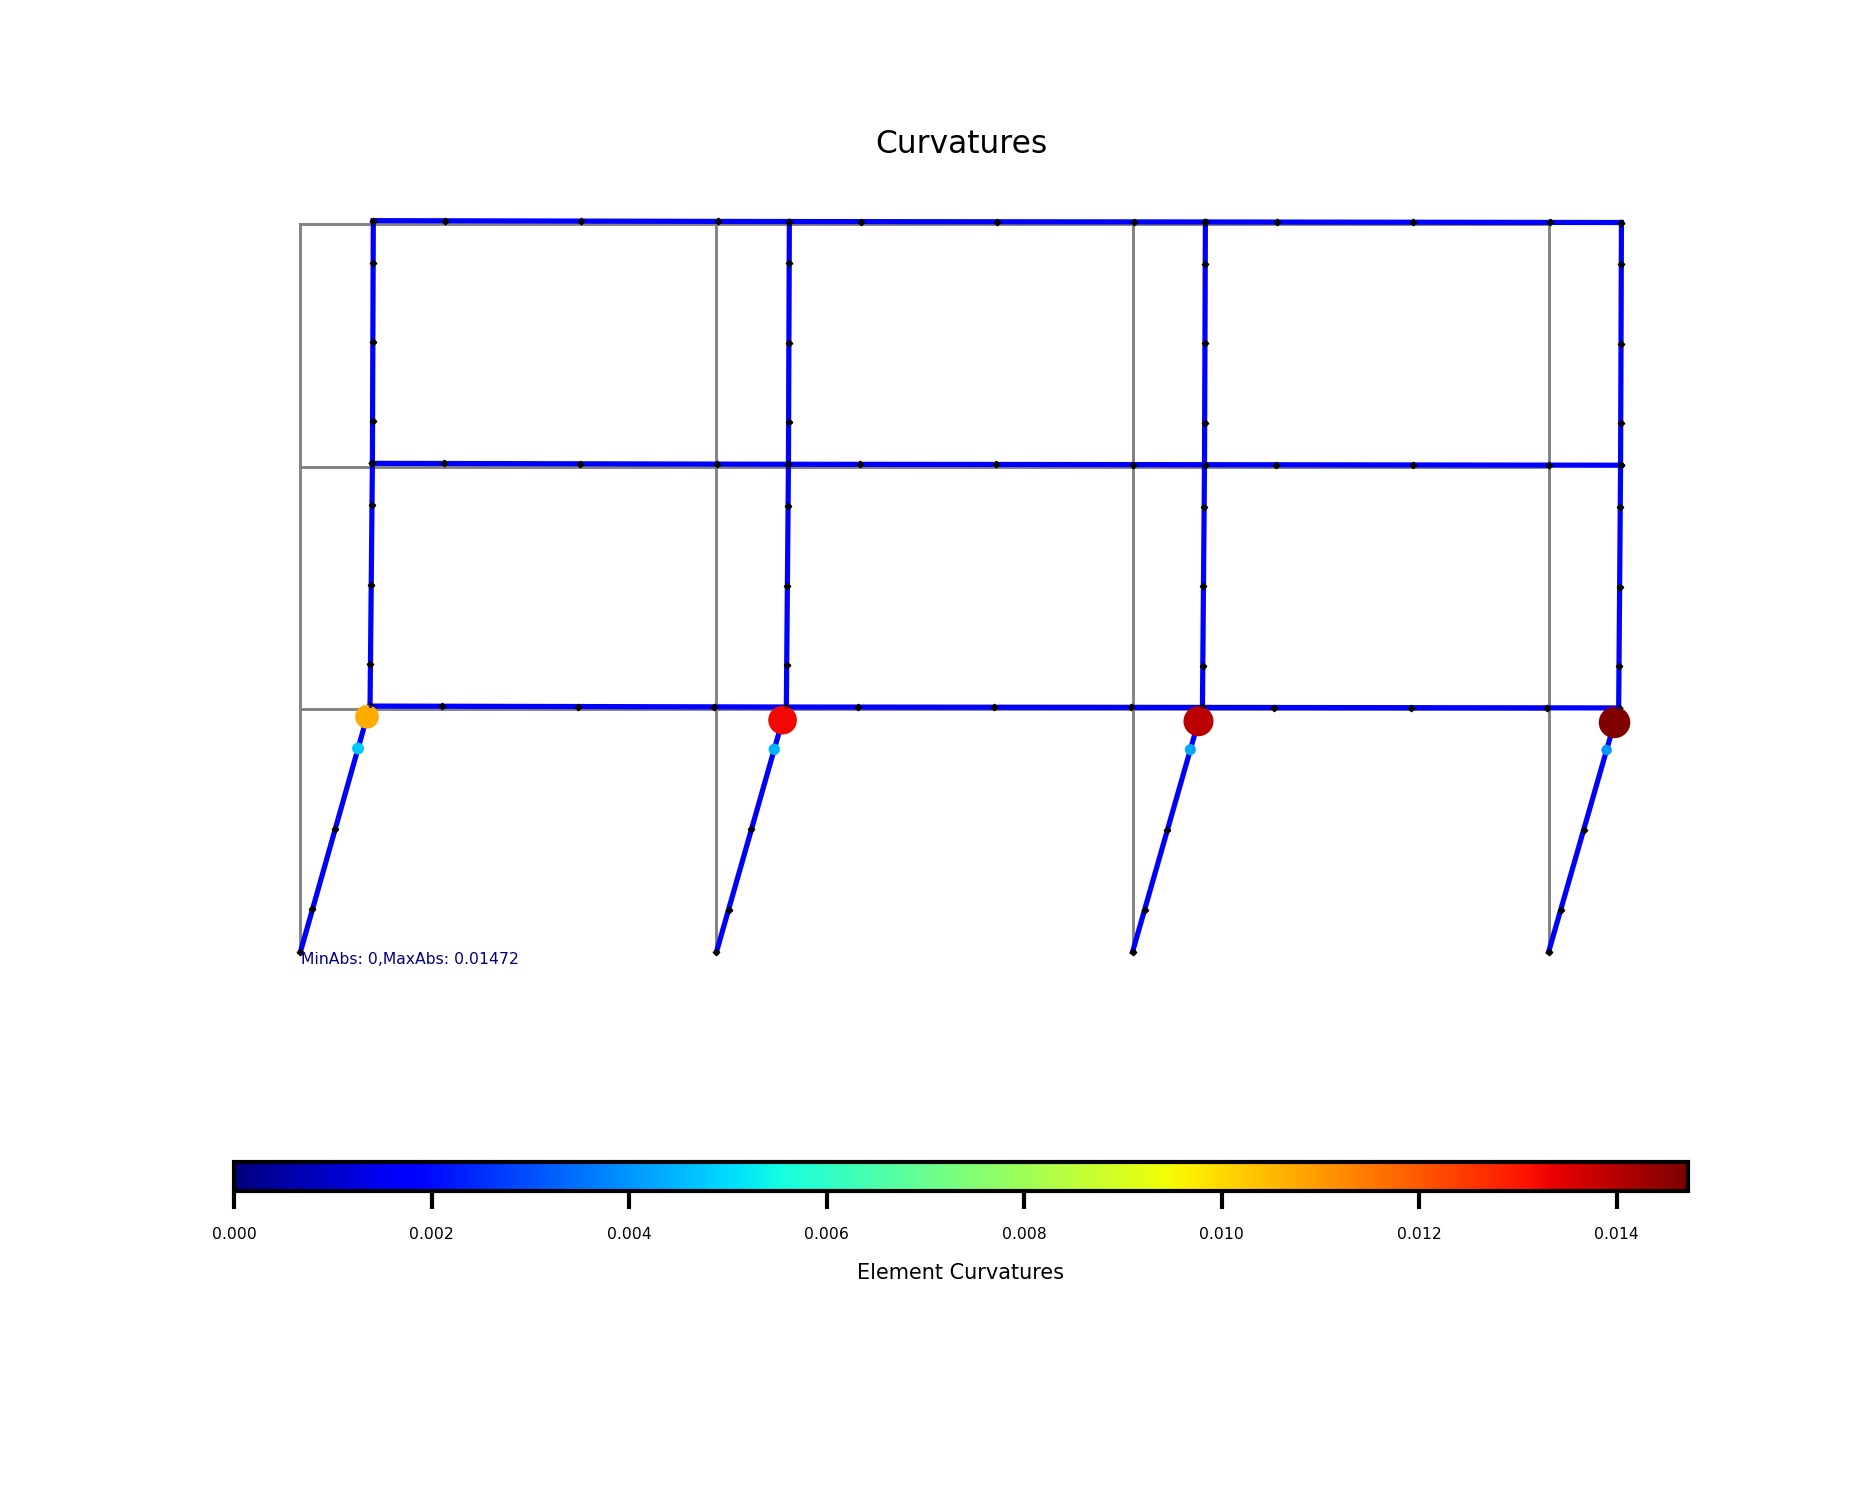

In [16]:
import matplotlib.cm as cm
NodeList = ops.getNodeTags()
nodeCoord = ops.nodeCoord(NodeList[0])
if len(nodeCoord)==1:
    Dim = '1D'
elif len(nodeCoord) == 2:
    Dim = '2D'
else:
    Dim = '3D'

if Dim == '3D':
    from mpl_toolkits import mplot3d
    figHNG = plt.figure('Curvatures_' +str(random.randint(1,100)),figsize=(figSizeH,figSizeV), dpi=DPI,facecolor='whitesmoke')
    axHNG = figHNG.add_subplot(1,1,1, projection='3d',facecolor='whitesmoke')
else:
    figHNG = plt.figure('Curvatures_' +str(random.randint(1,100)),figsize=(figSizeH,figSizeV), dpi=DPI, facecolor='w', edgecolor='k' )
    axHNG = figHNG.add_subplot(1,1,1)

AllCurvatures = []
AllElementSectionData = {}

allElementList =  ops.getEleTags()  

for thisElementTag in allElementList:
    AllElementSectionData[thisElementTag] = {}
    thisEleType = ops.eleType(thisElementTag)
    AllElementSectionData[thisElementTag]['ElementType'] = thisEleType
    secLocations = {}
    secWeights = {}
    secDefos = {}
    secCurvatures = {}
    thisLoclist = ops.eleResponse(thisElementTag,'integrationPoints')
    Nsections = len(thisLoclist)
    for thisIPtag in range(1,Nsections+1):
        thisLoc = ops.sectionLocation(thisElementTag,thisIPtag)
        if isinstance(thisLoc, float) or isinstance(thisLoc, int):
            secLocations[thisIPtag] = thisLoc
            secDefos[thisIPtag] = ops.eleResponse(thisElementTag,'section',thisIPtag,'deformation')
            thisCurvature = secDefos[thisIPtag][MomentTag]
            secCurvatures[thisIPtag] = abs(thisCurvature)
            AllCurvatures.append(abs(thisCurvature))
    AllElementSectionData[thisElementTag]['secLocations'] = secLocations
    AllElementSectionData[thisElementTag]['secDefos'] = secDefos
    AllElementSectionData[thisElementTag]['secCurvatures'] = secCurvatures
    AllElementSectionData[thisElementTag]['Nsections'] = Nsections

if len(AllCurvatures)>1:
    maxQuantity = max(AllCurvatures)
    ampFactor = ampFactor/maxQuantity

    QuantityValues = []
    QuantityValuesAmped = []
    StruxElements = []
    QuantityValuesNormalized = []
    XcoordList = []
    YcoordList = []
    ZcoordList = []
    XcoordList0 = []
    YcoordList0 = []
    ZcoordList0 = []

    cmap = cm.jet
    for thisElementTag,thisElementData in AllElementSectionData.items():
        thisEleType = AllElementSectionData[thisElementTag]['ElementType']
        eleNodesList = ops.eleNodes(thisElementTag)
        if len(eleNodesList)==2:
            [NodeItag,NodeJtag] = eleNodesList
            NodeCoordListI=ops.nodeCoord(NodeItag)
            NodeCoordListJ=ops.nodeCoord(NodeJtag)
            NodeDispI=ops.nodeDisp(NodeItag)
            NodeDispJ=ops.nodeDisp(NodeJtag)
            if len(NodeCoordListI)==1:
                [XcoordNodeI]=NodeCoordListI
                [XcoordNodeJ]=NodeCoordListJ
            elif len(NodeCoordListI) == 2:
                [XcoordNodeI,YcoordNodeI]=NodeCoordListI
                [XcoordNodeJ,YcoordNodeJ]=NodeCoordListJ
            else:
                Dim = "3D"
                [XcoordNodeI,YcoordNodeI,ZcoordNodeI]=transformAxes3D(NodeCoordListI,VerticalAxis)
                [XcoordNodeJ,YcoordNodeJ,ZcoordNodeJ]=transformAxes3D(NodeCoordListJ,VerticalAxis)                
                NodeDispI=transformAxes3D(NodeDispI,VerticalAxis)
                NodeDispJ=transformAxes3D(NodeDispJ,VerticalAxis)
        else:
            continue

        XcoordNodeIdefo = XcoordNodeI+ampFactorDefo*NodeDispI[0]
        XcoordNodeJdefo = XcoordNodeJ+ampFactorDefo*NodeDispJ[0]
        plotCoordList0 = [[XcoordNodeI,XcoordNodeJ]]
        plotCoordList = [[XcoordNodeIdefo,XcoordNodeJdefo]]
        ElementLength = math.sqrt((XcoordNodeJ-XcoordNodeI)*(XcoordNodeJ-XcoordNodeI))
        if len(NodeCoordListI)>1:
            YcoordNodeIdefo = YcoordNodeI+ampFactorDefo*NodeDispI[1]
            YcoordNodeJdefo = YcoordNodeJ+ampFactorDefo*NodeDispJ[1]
            plotCoordList0.append([YcoordNodeI,YcoordNodeJ])
            plotCoordList.append([YcoordNodeIdefo,YcoordNodeJdefo])
            ElementLength = math.sqrt((XcoordNodeJ-XcoordNodeI)*(XcoordNodeJ-XcoordNodeI)+(YcoordNodeJ-YcoordNodeI)*(YcoordNodeJ-YcoordNodeI))
        if len(NodeCoordListI)>2:
            ZcoordNodeIdefo = ZcoordNodeI+ampFactorDefo*NodeDispI[2]
            ZcoordNodeJdefo = ZcoordNodeJ+ampFactorDefo*NodeDispJ[2]
            plotCoordList0.append([ZcoordNodeI,ZcoordNodeJ])
            plotCoordList.append([ZcoordNodeIdefo,ZcoordNodeJdefo])
            ElementLength = math.sqrt((XcoordNodeJ-XcoordNodeI)*(XcoordNodeJ-XcoordNodeI)+(YcoordNodeJ-YcoordNodeI)*(YcoordNodeJ-YcoordNodeI)+(ZcoordNodeJ-ZcoordNodeI)*(ZcoordNodeJ-ZcoordNodeI))
        UnDeformedEleLineObject, = axHNG.plot(*plotCoordList0,'grey',linewidth = 0.55,zorder = 1)
        DeformedEleLineObject, = axHNG.plot(*plotCoordList,'blue',linewidth = 1,zorder = 2)

        if Dim == '3D':
            # we have rotated the coords such that Z is vertical
            if ZcoordNodeI == ZcoordNodeJ :
                StructuralElement = 'Beam'
            else:
                StructuralElement = 'Column'
        else:
            if XcoordNodeI == XcoordNodeJ:
                StructuralElement = 'Column'
            else:
                if YcoordNodeI == YcoordNodeJ:
                    StructuralElement = 'Beam'
                else:
                    StructuralElement = 'Other'
        ElementType = thisElementData['ElementType']

        if len(thisElementData['secCurvatures'])<1:
            continue
        if 'secLocations' in thisElementData.keys():
            Nsections = thisElementData['Nsections']
            for thisSecID in range(1,Nsections+1):
                thisLocation = thisElementData['secLocations'][thisSecID]
                thisQuantity = thisElementData['secCurvatures'][thisSecID]
                thisQuantityAmped = thisQuantity*ampFactor
                QuantityValues.append(thisQuantity)
                QuantityValuesAmped.append(thisQuantityAmped)
                QuantityValuesNormalized.append(thisQuantity/maxQuantity)
                thisElementClass = 'None'

                if thisLocation/ElementLength<.1 :
                    shiftFactor = +1
                elif thisLocation/ElementLength>0.9:
                    shiftFactor = -1
                else:
                    shiftFactor = 0
                thisCenter = thisLocation + shiftFactor*thisQuantityAmped
                thisXcoord0 = XcoordNodeIdefo + thisLocation*(XcoordNodeJdefo-XcoordNodeIdefo)/ElementLength
                thisYcoord0 = YcoordNodeIdefo + thisLocation*(YcoordNodeJdefo-YcoordNodeIdefo)/ElementLength
                thisXcoord = XcoordNodeIdefo + thisCenter*(XcoordNodeJdefo-XcoordNodeIdefo)/ElementLength
                thisYcoord = YcoordNodeIdefo + thisCenter*(YcoordNodeJdefo-YcoordNodeIdefo)/ElementLength
                if Dim == '3D':
                    thisZcoord0 = ZcoordNodeIdefo + thisLocation*(ZcoordNodeJdefo-ZcoordNodeIdefo)/ElementLength
                    thisZcoord = ZcoordNodeIdefo + thisCenter*(ZcoordNodeJdefo-ZcoordNodeIdefo)/ElementLength

                thisFill = True

                XcoordList0.append(thisXcoord0)
                YcoordList0.append(thisYcoord0)
                XcoordList.append(thisXcoord)
                YcoordList.append(thisYcoord)
                if Dim == '3D':
                    ZcoordList.append(thisZcoord)
                    ZcoordList0.append(thisZcoord0)

    if not Dim == '3D':
        ZcoordList = YcoordList


    if len(QuantityValuesAmped)>0:
        if Dim == '3D':
            points = axHNG.plot(XcoordList0,YcoordList0,ZcoordList0,'kx',markersize = 0.75)
        else:
            points = axHNG.plot(XcoordList0,YcoordList0,'kx',markersize = 0.75)
        # from https://stackoverflow.com/questions/51020192/circle-plot-with-color-bar
        colors = [cm.jet(color) for color in QuantityValuesNormalized]
        for thisXcoord,thisYcoord,thisZcoord,thisQuantityAmped,thisColor in zip(XcoordList,YcoordList,ZcoordList,QuantityValuesAmped,colors):
            if Dim == '3D':
                thisCircle = axHNG.scatter(thisXcoord, thisYcoord, thisZcoord, '.',color=thisColor,s=thisQuantityAmped,zorder=7)
            else:
                thisCircle = plt.Circle((thisXcoord, thisYcoord), thisQuantityAmped, color=thisColor, fill=thisFill,linewidth =0.5,zorder=7)
                axHNG.add_artist(thisCircle)

        scatterPlt = axHNG.scatter(XcoordList,YcoordList,s=0,c=QuantityValues,cmap='jet',facecolors='none')
        cbar = plt.colorbar(scatterPlt,ax=axHNG,aspect = 50, orientation="horizontal")  # this works because of the scatter       
        cbar.set_label('Element Curvatures',fontsize=AxisLabelFontSize)
        cbar.ax.tick_params(labelsize=tickFontSize)
        for t in cbar.ax.get_yticklabels():
             t.set_fontsize(tickFontSize)

    if Dim == '3D':
        line = axHNG.text(0.1,-0.1,0,'MinAbs: ' + str(eSEESminiPy.round_to_N(min(QuantityValues),4)) + ',MaxAbs: ' + str(eSEESminiPy.round_to_N(max(QuantityValues),4)),  fontsize=tickFontSize,verticalalignment = 'top', horizontalalignment='left',c='navy',zorder=3)
    else:
        line = axHNG.text(0.1,-0.1,'MinAbs: ' + str(eSEESminiPy.round_to_N(min(QuantityValues),4)) + ',MaxAbs: ' + str(eSEESminiPy.round_to_N(max(QuantityValues),4)),  fontsize=tickFontSize,verticalalignment = 'top', horizontalalignment='left',c='navy',zorder=3)

    if Dim == "3D":
        eSEESminiPy.set_aspect_equal_3d(axHNG)
    else:
        axHNG.set_aspect('equal', adjustable='box')

    plt.axis('off')


    axHNG.set_title(Title, fontsize=TitleFontSize)

    plt.show()


<IPython.core.display.Javascript object>


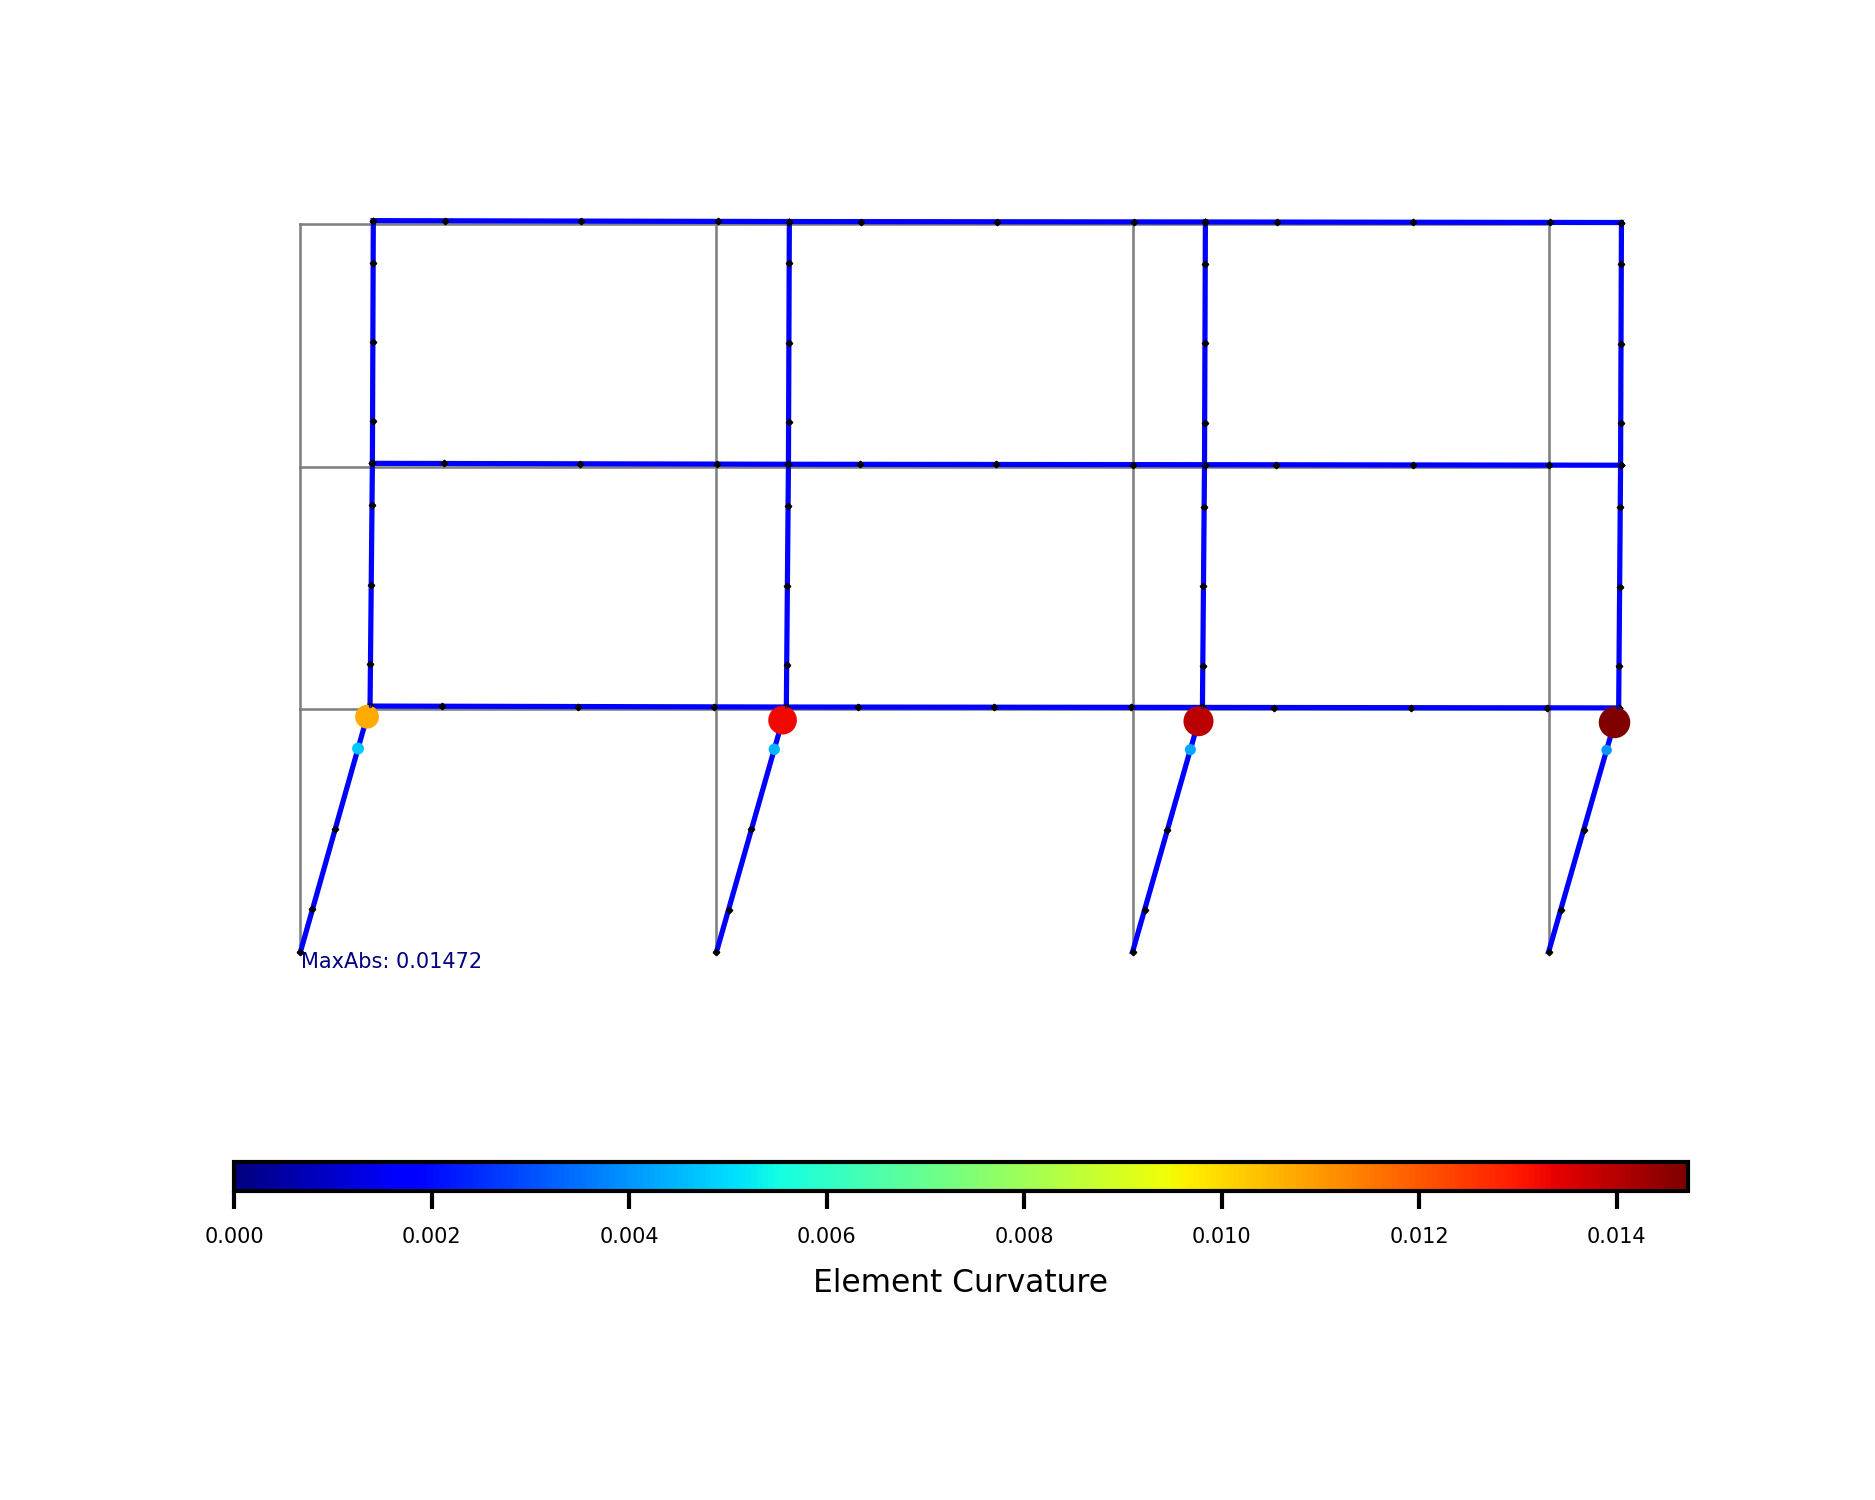

In [17]:
# you can do this easily with eSEESminPy:
eSEESminiPy.DrawCurvatures()